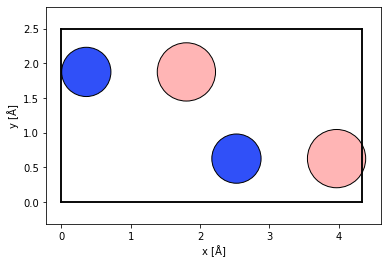

In [1]:
# Create an orthogonal unit cell of hBN using a graphene constructor.

import matplotlib.pyplot as plt
import numpy as np

from ase.lattice.hexagonal import Graphene
from abtem.structures import orthogonalize_cell
from abtem.visualize import show_atoms

# Lattice constant and perpendicular cell size.
lc = 2.5
vac = 12.0

structure = Graphene(symbol='C', latticeconstant={'a':lc, 'c':vac},
                      size=(1,1,1))
structure.pbc = True
structure[0].symbol='B'
structure[1].symbol='N'

# Orthogonalize cell
atoms = orthogonalize_cell(structure)
atoms.rotate(90, 'z', rotate_cell=True)
atoms.cell=[4.3284, 2.499, 12]
atoms.center()

show_atoms(atoms);

In [2]:
# Run a cheap DFT calculation to get the electrostatic potential.
# Takes less than a minute and requires less than 1 GB of memory.
# NOTE: requires the optional GPAW installation to run!

from gpaw import GPAW, FermiDirac, PW

gpaw = GPAW(mode=PW(350), basis='dzp', xc='PBE', 
            occupations=FermiDirac(0.01), kpts=(3,6,1),
            txt=None) # Remove to not suppress GPAW text output.

atoms.set_calculator(gpaw)
atoms.get_potential_energy()

-28.534208403277187

In [3]:
# Create DFT and independent atom potentials for the system.

from abtem import *
from abtem.potentials import Potential
from abtem.dft import GPAWPotential
from abtem.transfer import scherzer_defocus

potential_dft = GPAWPotential(gpaw, sampling=.04)
potential_iam = Potential(atoms, gpts=potential_dft.gpts, sampling=.04)

# Tile the potentials of the small unit cell to accommodate the full probe.
# While one could first tile the atoms and then create the potential for the larger cell,
# this would be quite expensive in terms of the required DFT calculation!
potential_dft = potential_dft.build().tile((2, 3))
potential_iam = potential_iam.build().tile((2, 3))

# Create near-ideal scanning probe.
alpha = 31.5
E = 80000
Csval = 1e5
df = scherzer_defocus(E, Csval)

probe = Probe(energy=E, semiangle_cutoff=alpha, defocus=df, Cs=Csval)

# Match probe grid to the DFT potential grid.
probe.grid.match(potential_dft)

# Scan the unit cell at slightly below Nyquist sampling.
gridscan = GridScan(start=[0,0], end=[atoms.cell[0][0], atoms.cell[1][1]], sampling=probe.ctf.nyquist_sampling*0.9)

# Define bright and dark field annular detectors.
bf_detector = AnnularDetector(inner=0, outer=alpha/2)
adf_detector = AnnularDetector(inner=3*alpha, outer=4*alpha)

In [4]:
# Running the multislice simulation for both potentials takes less than a minute.
measurements_iam = probe.scan(gridscan, [bf_detector, adf_detector], potential_iam)
measurements_dft = probe.scan(gridscan, [bf_detector, adf_detector], potential_dft)

Scan:   0%|          | 0/135 [00:00<?, ?it/s]

Scan:   0%|          | 0/135 [00:00<?, ?it/s]

In [5]:
# The detectors are indexed in the order they were defined.
#
# We tile the measurements to plot larger fields of view,
# and then plot diffractograms of the bright field measurements.
#
# Due to the Nyquist sampling, the measurements can also be interpolated 
# down to the potential spacing without artifacts.

bf_iam = measurements_iam[0].interpolate(0.04).tile((2,3))
adf_iam = measurements_iam[1].interpolate(0.04).tile((2,3))
diff_iam = measurements_iam[0].tile((2,3)).diffractograms()

bf_dft = measurements_dft[0].interpolate(0.04).tile((2,3))
adf_dft = measurements_dft[1].interpolate(0.04).tile((2,3))
diff_dft = measurements_dft[0].tile((2,3)).diffractograms()

In [6]:
# Create line profiles over the B and N atoms, and diffractions spots.
# First tile also the atoms.
atoms2 = atoms.repeat((2,3,1))

# Pick indices of atoms and margin for how much beyond their positions to plot the lines.
atN = 19
atB = 18
mar = 1.4

# Define reciprocal space line profile center position.
dcent = (0, 1/lc)

# Create interpolated line profiles.
l_bf_iam = bf_iam.interpolate_line(atoms2[atN], atoms2[atB], margin=mar, sampling=0.04)
l_adf_iam = adf_iam.interpolate_line(atoms2[atN], atoms2[atB], margin=mar, sampling=0.04)
l_diff_iam = diff_iam.interpolate_line(dcent, margin=1.0, sampling=0.04, interpolation_method='linear')

l_bf_dft = bf_dft.interpolate_line(atoms2[atN], atoms2[atB], margin=mar, sampling=0.04)
l_adf_dft = adf_dft.interpolate_line(atoms2[atN], atoms2[atB], margin=mar, sampling=0.04)
l_diff_dft = diff_dft.interpolate_line(dcent, margin=1.0, sampling=0.04, interpolation_method='linear')

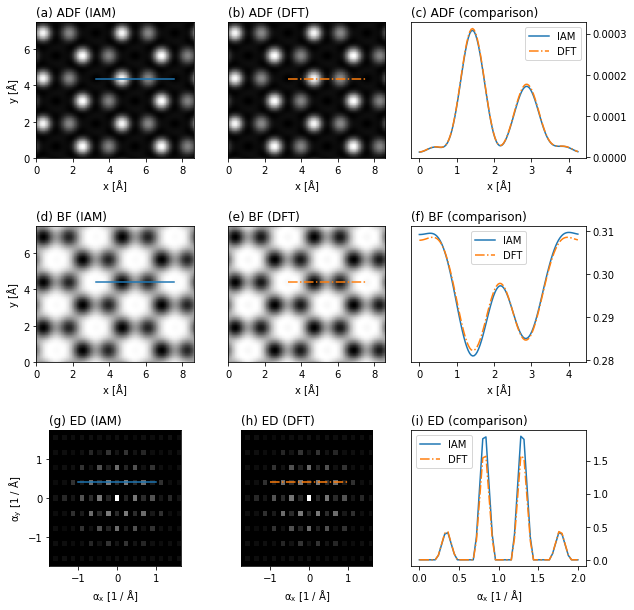

In [33]:
# Plot a figure of the results.

from matplotlib import pyplot as plt

fig, axes = plt.subplots(3, 3, figsize=(10,10), gridspec_kw={'hspace': 0.5, 'wspace': 0.1})

adf_iam.show(ax=axes[0,0], equal_ticks=True)
adf_dft.show(ax=axes[0,1], equal_ticks=True)
l_adf_iam.add_to_mpl_plot(ax=axes[0,0], color='tab:blue')
l_adf_dft.add_to_mpl_plot(ax=axes[0,1], color='tab:orange', linestyle='-.')
l_adf_iam.show(ax=axes[0,2], color='tab:blue', label='IAM')
l_adf_dft.show(ax=axes[0,2], color='tab:orange', label='DFT', linestyle='-.')

axes[0,0].set_title('(a) ADF (IAM)', x=0, ha='left')
axes[0,1].set_title('(b) ADF (DFT)', x=0, ha='left')
axes[0,1].yaxis.set_visible(False)
axes[0,2].set_title('(c) ADF (comparison)', x=0, ha='left')

bf_iam.show(ax=axes[1,0], equal_ticks=True)
bf_dft.show(ax=axes[1,1], equal_ticks=True)
l_bf_iam.add_to_mpl_plot(ax=axes[1,0], color='tab:blue')
l_bf_dft.add_to_mpl_plot(ax=axes[1,1], color='tab:orange', linestyle='-.')
l_bf_iam.show(ax=axes[1,2], color='tab:blue', label='IAM')
l_bf_dft.show(ax=axes[1,2], color='tab:orange', label='DFT', linestyle='-.')

axes[1,0].set_title('(d) BF (IAM)', x=0, ha='left')
axes[1,1].set_title('(e) BF (DFT)', x=0, ha='left')
axes[1,1].yaxis.set_visible(False)
axes[1,2].set_title('(f) BF (comparison)', x=0, ha='left')

diff_iam.show(ax=axes[2,0], power=0.08)
diff_dft.show(ax=axes[2,1], power=0.08)
l_diff_iam.add_to_mpl_plot(ax=axes[2,0], color='tab:blue')
l_diff_dft.add_to_mpl_plot(ax=axes[2,1], color='tab:orange', linestyle='-.')
l_diff_iam.show(ax=axes[2,2], color='tab:blue', label='IAM')
l_diff_dft.show(ax=axes[2,2], color='tab:orange', label='DFT', linestyle='-.')

axes[2,0].set_title('(g) ED (IAM)', x=0, ha='left')
axes[2,0].set_xlabel(r'$\mathrm{\alpha_x}$ [1 / Å]')
axes[2,0].set_ylabel(r'$\mathrm{\alpha_y}$ [1 / Å]')
axes[2,1].set_title('(h) ED (DFT)', x=0, ha='left')
axes[2,1].set_xlabel(r'$\mathrm{\alpha_x}$ [1 / Å]')
axes[2,1].yaxis.set_visible(False)
axes[2,2].set_title('(i) ED (comparison)', x=0, ha='left')
axes[2,2].set_xlabel(r'$\mathrm{\alpha_x}$ [1 / Å]')

for ax in (axes[0,2], axes[1,2], axes[2,2]):
    ax.yaxis.tick_right()
    ax.legend()
    
plt.savefig('hBN.pdf')